This notebook presents a baseline model for Kaggle's recently completed Toxic Comment Classification Challenge.
I have used pretrained GloVe word vctors. I have tried to mimic the idea of attention mechanism present in the paper https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf. The basic idea is, not all words contribute equally to the representation of the sentence meaning. Hence, the authors of this papers introduced attention mechanism to extract such words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector. The LB score for this model was 0.9840. I trained model only for 3 epochs. No text cleaning or special preprocessing was done.

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Bidirectional, LSTM, GRU, Embedding, Reshape, Multiply, Activation
from keras.layers import Conv1D, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers import Lambda, concatenate, TimeDistributed, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
TRAIN_DATA_FILE = 'train.csv'
TEST_DATA_FILE = 'test.csv'

In [3]:
embed_size = 300          #word vector size
max_features = 100000     #max words to work with
max_len = 150             #max number of words in a comment to use 

In [4]:
#Load data
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

print("Total number of comments in training data: {}".format(train.shape[0]))
print("Total number of comments in test data: {}".format(test.shape[0]))

Total number of comments in training data: 159571
Total number of comments in test data: 153164


In [5]:
#Let's see few rows of our train data
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
#Separate comments and labels as our features and classes
classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
train_y = train[classes].values
train_x = train['comment_text'].str.lower()
test_x = test['comment_text'].str.lower()

In [7]:
#Do we have any missing values in our train and test data
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [8]:
#Prepare GloVe embedding
embeddings_index = {}

#Read the GloVe word vectors
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
#Vectorize text
tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(train_x)+list(test_x))
train_sequence = tokenizer.texts_to_sequences(train_x)
test_sequence = tokenizer.texts_to_sequences(test_x)

In [10]:
print("Total number of unique tokens found: {}".format(len(tokenizer.word_index)))

Total number of unique tokens found: 394787


(array([26691., 22100., 16260., 12907., 10179.,  7728.,  6106.,  4863.,
         3922.,  3307.,  2790.,  2397.,  1934.,  1738.,  1464.,  1445.,
         1291.,  1092.,   833.,   805.,   776.,   606.,   574.,   521.,
          477.,   417.,   391.,   409.,   269.,   296.,   272.,   219.,
          186.,   160.,   172.,   152.,   154.,   138.,   137.]),
 array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
        270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
        400]),
 <a list of 39 Patch objects>)

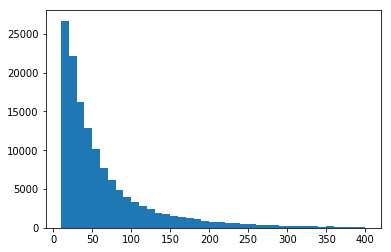

In [11]:
#Let's see the distribution of lengths of training sequences
train_sequence_length = [len(sequence) for sequence in train_sequence]
plt.hist(train_sequence_length, bins=np.arange(10, 410, 10))

In [12]:
#From distribution above we can see that most of the sequences have length less than 100, 
#for safer side we will keep max_len as 150
x_t = pad_sequences(train_sequence, max_len)
x_te = pad_sequences(test_sequence, max_len)
x_t.shape

(159571, 150)

In [13]:
common_words_count = 0
uncommon_words =[]
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        common_words_count +=1
    else:
        uncommon_words.append(word)

In [14]:
print("Number of common words in Glove and our vocabulary : {}".format(common_words_count))
print("Number of uncommon words in Glove and our vocabulary : {}".format(len(uncommon_words)))
print("Shape of Embedding matrix: {}".format(embedding_matrix.shape))

Number of common words in Glove and our vocabulary : 73366
Number of uncommon words in Glove and our vocabulary : 26633
Shape of Embedding matrix: (100000, 300)


In [15]:
#Split the training set in train and validation set
x_train, x_val, y_train, y_val = train_test_split(x_t, train_y, test_size=0.1, random_state=233) 

In [16]:
filepath="weights_base.best.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

earlyStopping = EarlyStopping(monitor="val_acc", mode="max", patience=3)

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            
ra_val = RocAucEvaluation(validation_data=(x_val, y_val), interval=1) 
callback_list = [ra_val, checkpoint, earlyStopping]

In [17]:
inp = Input(shape=(max_len,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.35)(x)
h = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
u = TimeDistributed(Dense(128, activation='relu', use_bias=False))(h)
alpha = TimeDistributed(Dense(1, activation='relu'))(u)
x = Reshape((max_len,))(alpha)
x = Activation('softmax')(x)
x = Reshape((max_len, 1))(x)
x = Multiply()([h, x])
x = Lambda(lambda x: K.sum(x, axis=1))(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 256)     439296      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
time_distr

In [18]:
batch_size=128
model.fit(x_train, y_train, batch_size=batch_size, epochs=3, validation_data=(x_val, y_val), callbacks=callback_list)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143488/143613 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9785
 ROC-AUC - epoch: 1 - score: 0.982933 

Epoch 00001: val_acc improved from -inf to 0.98306, saving model to weights_base.best.h5
143613/143613 [==============================] - 668s 5ms/step - loss: 0.0640 - acc: 0.9785 - val_loss: 0.0444 - val_acc: 0.9831
Epoch 2/3
143488/143613 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9837
 ROC-AUC - epoch: 2 - score: 0.986470 

Epoch 00002: val_acc improved from 0.98306 to 0.98388, saving model to weights_base.best.h5
143613/143613 [==============================] - 662s 5ms/step - loss: 0.0424 - acc: 0.9837 - val_loss: 0.0422 - val_acc: 0.9839
Epoch 3/3
143488/143613 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9852
 ROC-AUC - epoch: 3 - score: 0.987124 

Epoch 00003: val_acc did not improve
143613/143613 [==============================] - 659s 5ms/step - 